## General

a supervised pipeline including encoding-> scaling -> feature reduction -> classifier 
for any target variable chosen. 

The supervised classifier is used for verification of the unsupervised patterns that were recognized with PCA and Kmeans. 
Based on the results of the supervised learning, the questions that might be asked by the politicians and professionals could be formulated. 

### Imports

In [24]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
import re
import math

In [25]:
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    label_binarize
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import category_encoders as ce
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc


from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression



### Globals

In [26]:
DATA_BASEPATH = "./data/data-science-for-good/versions/18"
CENSUS_ZIPFILES = "./data/census_zip_shapefiles"
PROCESSED_CSVS = "./data/processed_csv"
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")
CENSUS_SHAPE_PATH = os.path.join(DPT_ACS_PATH, "census_shapefiles")

POLICE_SHAPE_FOLDER = os.path.join(DATA_BASEPATH, f"DEPT_{dpt}", f"{dpt}_Shapefiles")

In [27]:
warnings.filterwarnings("ignore")
sns.set_style(style="white")
pd.set_option("display.width", None)
%matplotlib widget

### Helper functions

In [28]:
# feature engineering:


def count_encode_officer_id(X):
    """
    counts the amount of violations per officer by officer ID
    Args:
        X: dataframe
    returns:
        dataframe
    """
    df = X.copy()
    officer_id_counts = df["OFFICER_ID"].value_counts()
    supervisor_id_counts = df["OFFICER_SUPERVISOR"].value_counts()
    df["OFFICER_ID_COUNT"] = df["OFFICER_ID"].map(officer_id_counts)
    df["OFFICER_SUPERVISOR_COUNT"] = df["OFFICER_SUPERVISOR"].map(supervisor_id_counts)
    df = df.drop(columns=["OFFICER_ID", "OFFICER_SUPERVISOR"])
    return df


# cyclical encoding for weekday and months
def cyclical_encoder(X):
    """encodes with cycles for weekday and month of the violation"""
    df = X.copy()
    df["WEEKDAY_SIN"] = np.sin(2 * np.pi * df["WEEKDAY"] / 7)
    df["WEEKDAY_COS"] = np.cos(2 * np.pi * df["WEEKDAY"] / 7)
    df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
    df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)
    df = df.drop(columns=["WEEKDAY", "MONTH"])
    return df


# encode month-year into ordinal numeric
def month_year_encoder(X):
    """encodes the month-year column into numerical ordinal column"""
    X["month_year_index"] = (
        (X["month_year"].dt.year - X["month_year"].dt.year.min()) * 12
        + X["month_year"].dt.month
    ).astype("float")
    X = X.drop(columns="month_year")
    return X


# choice of scaler:
# - we know that the data is definately not normal distributed. there are many outliers and big bias
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
# therefore no standard scaler (for normally distributed data)
# first scale with MinMax, then try with Robust


def scale_numerical_variables(X, scaler="minmax"):
    """
    scales the dataset and returns a scaled array
    Args:
        X - dataframe or array with only numerical features to scale
        scaler: str = 'minmax' or 'robust'
    """
    if scaler == "minmax":
        scaler = MinMaxScaler()
    elif scaler == "robust":
        scaler = RobustScaler()
    else:
        scaler = None
        print('scaler must be defined as "minmax" or "robust"')
        return

    return scaler.fit_transform(X)

In [29]:
## plotting pca and kmeans


# choose and plot PCA elbow score:
def calc_plot_pca_value(X, n_components=None):
    """
    tests the optimal value for n_components for PCA for the dataset.
    Plots the elbow score for each value
    Args:
        X: pd.DataFrame | dataset

    """
    # elbow plot for the best PCA value: nr_features vs. added explained variance
    pca = PCA(n_components=n_components)
    pca.fit(X)
    np.random.seed(90)

    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_var_ratio)

    # 4. Plot
    plt.figure(figsize=(6, 4))
    plt.plot(
        range(1, len(cumulative_explained_variance) + 1),
        cumulative_explained_variance,
        marker="o",
        linestyle="--",
    )
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Elbow Score: Comulative PCA Explained Variance")
    plt.grid(True)
    plt.xticks(np.arange(0, len(cumulative_explained_variance) + 1))
    plt.ylim(0, 1.05)

    # Highlight the elbow point (e.g., at 95% variance)
    target_variance = 0.8
    num_components_at_target = (
        np.argmax(cumulative_explained_variance >= target_variance) + 1
    )
    plt.axvline(
        x=num_components_at_target,
        color="r",
        linestyle=":",
        label=f"{target_variance*100}% Variance at {num_components_at_target} Components",
    )
    plt.legend()
    plt.show()


def scree_plot_for_selected_pca_value(X, n_components=3):

    pca = PCA(n_components=n_components)
    pca.fit_transform(X)
    var_ratio = pca.explained_variance_ratio_

    components = range(1, len(var_ratio) + 1)

    plt.figure(figsize=(6, 5))

    # Plot the explained variance as a bar chart
    plt.bar(components, var_ratio, color="skyblue", label="Explained Variance")

    # label each bar with its value
    for i, v in enumerate(var_ratio):
        plt.text(i + 1, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

    # Plot the cumulative explained variance as a line plot
    cumulative_variance = np.cumsum(var_ratio)
    plt.plot(
        components,
        cumulative_variance,
        marker="o",
        linestyle="--",
        color="red",
        label="Cumulative Variance",
    )

    # label the far end of the cumulative line with the cumulative value
    last_component = components[-1]
    last_cumulative_variance = cumulative_variance[-1]
    plt.text(
        last_component,
        last_cumulative_variance + 0.02,
        f"{last_cumulative_variance:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="red",
    )

    # Add labels and title
    plt.title("Scree Plot", fontsize=16)
    plt.xlabel("Principal Components", fontsize=12)
    plt.ylabel("Explained Variance Ratio", fontsize=12)
    plt.xticks(components)
    plt.legend()
    plt.show()


def plot_pca_3d(X_pca, labels, title="3D PCA Clustering"):
    """
    Plots a 3D scatterplot of PCA-reduced data with cluster labels.

    Args:
        X_pca: np.array, shape (n_samples, 3), PCA-transformed data
        labels: cluster assignments (array-like)
        title: str
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Colors for clusters
    # colors = cm.nipy_spectral(labels.astype(float) / max(labels.max(), 1))

    # custom_colors = ["tab10"]

    # Pick colors based on labels
    # colors = [custom_colors[l % len(custom_colors)] for l in labels]
    colors = cm.nipy_spectral(labels.astype(float) / max(labels.max(), 1))
    # Scatter plot in 3D
    ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, s=20, edgecolor="k", alpha=0.7
    )

    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.set_title(title)

    # Allow interactive rotation
    plt.tight_layout()
    plt.show()


# testing for different k
def test_k(k0, k1, X):
    """
    plots and calculate wcss and between cluster distance for k means for defined k values
    Args:
        k0: int | the first value to define the list range for k to be tested
        k1: int | the last list value
        X: np.array | to be clustered
    Returns:
        list k values, a list of wcss scores, a list of silhouette scores
    """
    wcss = []
    sil_scores = []
    k_values = range(k0, k1)
    fig = plt.figure(figsize=(12, 15))
    ax_range = math.ceil(np.sqrt(len(k_values)))
    index = 1
    for k in k_values:

        ax = fig.add_subplot(ax_range, ax_range, index, projection="3d")
        kmeans = KMeans(n_clusters=k, random_state=90, n_init="auto")
        db_labels = kmeans.fit_predict(X)

        # collect scores
        wcss.append(kmeans.inertia_)
        if k > 1:
            sil = silhouette_score(X, db_labels)
            print(f"silhouette for k {k} done")
        else:
            sil = 0
        sil_scores.append(sil)
        index += 1
        # plot clusters
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=db_labels, cmap="PiYG", s=20)
        ax.set_title(f"k = {k}")
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    return k_values, wcss, sil_scores


def plot_kmeans_scores(k_values, wcss, sil_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(k_values, wcss, "bx-")  # 'bx-' creates blue markers with a line
    ax2.plot(k_values, sil_scores, "bx-")  # 'bx-' creates blue markers with a line
    ax1.set_xlabel("k")
    ax2.set_xlabel("k")
    ax1.set_ylabel("Within-Cluster Sum of Squares (WCSS)")
    ax2.set_ylabel("Between-Cluster Sum of Squares (Silhouette)")
    ax1.set_title("The Elbow Method for Optimal k")
    ax2.set_title("The Silhouette Method for Optimal k")
    plt.xticks(k_values)
    plt.suptitle("Metrics for Optimal K")
    plt.show()

In [30]:
#

### Load

In [31]:
merged_dpt_census = pd.read_csv(
    "./data/processed_csv/04_combined_dpt_tract.csv",  converters={"month_year": lambda x: pd.Period(x, freq="M")},
)
merged_dpt_census.shape

(137375, 147)

In [32]:
# convert variable names:
dpt = "11-00091"
DPT_ACS_PATH = os.path.join(DATA_BASEPATH, f"Dept_{dpt}", f"{dpt}_ACS_data")

# list all the acs folders
dpt_acs_files = [file for file in os.listdir(DPT_ACS_PATH) if "ACS" in file]

metadata_dfs = {}
# create a df for each csv of every category
demographics = [
    "education-attainment",
    "education-attainment-over-25",
    "employment",
    "income",
    "owner-occupied-housing",
    "poverty",
    "race-sex-age",
]
for category in demographics:
    for folder in dpt_acs_files:
        if folder.endswith(category):
            cat_folder = os.path.join(DPT_ACS_PATH, folder)

            # collect data and metadata csv
            for i in ["ann", "metadata"]:
                csv_name = [csv for csv in os.listdir(cat_folder) if i in csv][0]
                csv_path = os.path.join(cat_folder, csv_name)

                if i == "metadata":
                    col_names = ["code", "description"]
                    df = pd.read_csv(csv_path, header=None, names=col_names)
                    metadata_dfs[category] = df

### methodology

The clusters and PCs are heavily influenced by demographic factors (race, district) and a few key police-related variables. PC1 is "black oriented" and PC2 is "white oriented", for example, and suggests the natural structure of the data, as seen from the PCA loadings analysis.

To validate the findings from Part 1 and answer specific questions about causation or influence, supervised analysis can be performed, with the SUBJECT_RACE as target variable. 
A secondary variable can be VIOLATION_OUTCOME, to test the performance of the police departments.

For this purpose the follwoing steps will be performed: 
1. CatBoost with the target variable
2. Scaling with MinMax scaler
3. Feature selection with Lasso and the target variable, in a Logistic Regression model. 

Log-Reg is a good fit for classification problems therefore will be good for the feature selection

the quality of prediction can be tested with ROC AOC of a model with both target variables.if the results are different and stronger for SUBJECT_RACE target variable, we can assume that the subject race is more visible from the demographics data, than the violation_outcome, which also has a positive conclusion for the police departments: they are not biased - from the data

dimensionality reduction: 
Decision tree is not fitting here since there are too many vairables. this is why we use lasso here.

**TODO: what about random forest?** 

## Catboost encoding: Scaler Testing

In [33]:
def get_column_categories(target_col):
    target_labels = merged_dpt_census[target_col]

    # map out the columns for processing: encoding and scaling
    categorical_cols = [
        "OUTCOME",
        "SUBJECT_GENDER",
        "LOCATION_DISTRICT",
        "SUBJECT_PRIORS",
        "SUBJECT_RACE",
        "SUBJECT_COMPLEXTION",
        "FIOFS_TYPE",
        "TERRORISM",
        "GROUPED_VIOLATION_REASON",
        "OFFICER_ASSIGNMENT.1",
        "OFFICER_RACE",
        "OFFICER_AGE_GROUP",
        "YEAR",
    ]
    nummerical_cols = [
        
        "OFFICER_SUPERVISOR",
        "WEEKDAY",
        "MONTH",
        "OFFICER_ID",
        "OFFICER_AGE",
    ]

    drop_cols = ["INCIDENT_UNIQUE_IDENTIFIER.1", 'VIOLATION_REASON','INCIDENT_DATE']
    date_cols = ["INCIDENT_DATE", "month_year"]

    col_dict = {'categorical_cols': categorical_cols, 'nummerical_cols': nummerical_cols, 'date_cols': date_cols, 'drop_cols':drop_cols}
    categorical_cols.remove(target_col)
    return col_dict


In [34]:
def get_X_y_raw(df, target_col, col_dict):
    X_raw = df.drop(columns=target_col)
    X_raw = X_raw.drop(columns=col_dict['drop_cols'])
    y_raw = df[target_col]

    return X_raw, y_raw

In [35]:
def implement_custom_encoders(X):
# cyclical encoding weekday and month
    X = cyclical_encoder(X)
    # numerical features: encode by count incidents per officer-id, officer-supervisor
    X = count_encode_officer_id(X)
    X = month_year_encoder(X)
    return X


In [36]:
target_col = "SUBJECT_RACE"
col_dict = get_column_categories(target_col)

X_raw, y_raw = get_X_y_raw(df=merged_dpt_census,target_col=target_col, col_dict=col_dict)

X_raw = implement_custom_encoders(X_raw)


In [37]:
# def get_catboost_encoding(X, target_col, categorical_cols):
def get_catboost_encoding(X_raw, target_col, col_dict):
    """maps the different categories of the target column to true/false with the other columns"""
    categorical_cols = col_dict['categorical_cols']
    encoder = ce.CatBoostEncoder(cols=categorical_cols, random_state=90)
    X_encoded = encoder.fit_transform(X_raw[categorical_cols], target_col)

    return X_encoded

The next steps  are run manually, external to the pipeline, to test which scaler fits more. 

In [38]:
# catboost encoding for categorical variables based on outcome
X_for_scaling = X_raw.copy()

X_encoded = get_catboost_encoding(
    X_for_scaling, target_col=y_raw,col_dict=col_dict
)


cat_cols = col_dict['categorical_cols']
X_for_scaling[cat_cols] = X_encoded

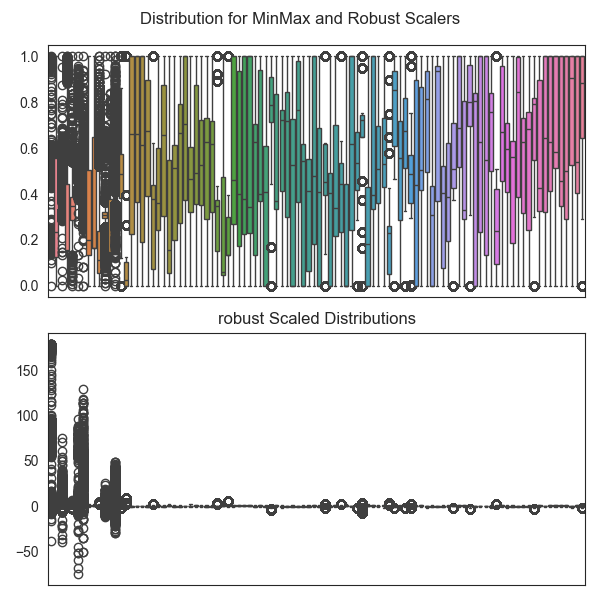

In [39]:
fig, ax = plt.subplots(2,1, figsize=(6,6))
fig.suptitle('Distribution for MinMax and Robust Scalers')
for i, scaler in enumerate(['minmax', 'robust']):
    scaled_df = scale_numerical_variables(X_for_scaling, scaler)
    
    sns.boxplot(data=scaled_df[:,:100], ax=ax[i])
    plt.title(f"{scaler} Scaled Distributions")
    ax[i].set_xticklabels([])
    plt.tight_layout()
plt.show()


Minmax scaler seems to capture better the variance of the data

## Feature Selection and Classification Pipeline: 

### Pipeline Setting

the pipeline is built of different steps: 
1. encoding, scaling and feature selection pipeline, with a grid search with cross validation for the best penalty value. 
2. based on feature selection, extraction of the most informative features - by name and description (from the metadata)
3. based on feature selection: running a classification model on the target variable.
4. evaluation: Plotting the loss function, the confusion matrix of the output categories and the ROC-AOC curves. 

In [40]:
def set_pipeline(col_dict, cv=5):
    """ 
    set sklearn encoding, min-max scaler, feature selection with logaritmic regression and grid-search
    Args: 
        cv: int | number of folds for the cross validation of the GridSearch
    Returns: 
        Sklearn Pipeline, GridSearch objects"""
    
    categorical_cols = col_dict['categorical_cols']
    preprocessor = ColumnTransformer(
        transformers=[
            ('catboost', ce.CatBoostEncoder(random_state=90), categorical_cols),
        ],
        remainder="passthrough",
    )

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('scaler', MinMaxScaler()),
            ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))),  
       
        ]
    )

    search = GridSearchCV(pipeline,
                        {'selector__estimator__C':np.arange(0.01,0.05,0.01)},
                        cv = cv, scoring="neg_mean_squared_error",verbose=3        #cv=cross validation to 5 k
                        )
    
    return pipeline, search

In [41]:
def get_feature_description(feature_names, metadata_dfs=metadata_dfs):
    feature_descriptions = []

    for i in feature_names:
        parts = i.rsplit("_", 1)
        var_code = parts[0]
        cat = parts[1]
        if cat in demographics:
            var_code = var_code.replace("remainder__", "")

            df = metadata_dfs[cat]
            description = df["description"].loc[df["code"] == var_code].values[0]

            feature_descriptions.append(f"{description}_{cat}")

        else:
            feature_descriptions.append("--")

    print(f"number of new names {len(feature_descriptions)}")
    return feature_descriptions

In [42]:
def get_coef_df(feature_names, grid_search):
    """ collects the coefficient from the best result cv log reg estimator
    Args: 
        extracted feature names from estimator

    Returns: 
        Pandas dataframe with feature names, descriptions, importance and coefficient
    """

    feature_descriptions = get_feature_description(feature_names)
    logreg_params = grid_search.best_estimator_.named_steps['selector'].estimator_
    coefs = logreg_params.coef_[0] 
    importance = np.abs(coefs)
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "description": feature_descriptions,
        "coefficient": coefs,
        "importance": importance
    }).sort_values("importance", ascending=False)

    # update pipeline with best c and add classifiction logistic regression

    return coef_df

In [84]:
def calc_plot_cm(y_test, y_pred, target_col):
    con_m = confusion_matrix(y_test, y_pred, labels=np.unique(y_pred))
    display = ConfusionMatrixDisplay(confusion_matrix=con_m,
                              display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_title(f"Confusion Matrix prediction for {target_col}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    display.plot(cmap="Blues", ax=ax, xticks_rotation=0)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=6, wrap=True)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=6, wrap=True)
   
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    plt.subplots_adjust(left=0.25)
    plt.show()

In [75]:
# ROC-AOC
def plot_roc(pipeline, X_test, y_test, target_col):
    # get class probabilities
    y_score= pipeline.predict_proba(X_test)

    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {cls} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multi-class ROC Curve (Logistic Regression) for: {target_col}")
    plt.legend(loc="lower left",
        bbox_to_anchor=(0.7, 0),
        #ncol=2,  # split legend into multiple columns if many classes
    fontsize=8)
    plt.subplots_adjust(right=0.7)
    plt.show()



In [45]:
def plot_learning_curve(pipeline, X_train, y_train, cv=5, scoring="accuracy"):
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X_train, y_train,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 8),  # 8 points between 10% and 100% of training data
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_mean, 'o-', label="Validation score")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel(scoring)
    plt.title("Learning Curve (Pipeline with Logistic Regression)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [81]:
def pipeline_runner(df, target_col):

    
    col_dict = get_column_categories(target_col)

    X_raw, y_raw = get_X_y_raw(df=df,target_col=target_col, col_dict=col_dict)

    X_raw = implement_custom_encoders(X_raw)

    pipeline, search = set_pipeline(col_dict)

    # we know that there is an imbalance in the subject race classes, therefore use stratify to keep the shares of each class in the test-train sets.
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.33, random_state=90, stratify=y_raw) 

    # search for best penalty parameter c: 
    search.fit(X_train,y_train)
    best_c = search.best_params_['selector__estimator__C']
    print(best_c)

    # get the importance of the parameters by name and description: 
    best_model = search.best_estimator_
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    support = best_model.named_steps['selector'].get_support()
    selected_features = feature_names[support]
    print(f'number of selected features with lasso: {len(selected_features)}')
    
    coef_df = get_coef_df(feature_names, grid_search=search)
    
    # update model: add best_c and add threshold of importance= 0.001 
    pipeline.set_params(selector__estimator__C=best_c)
    pipeline.set_params(selector__threshold=0.001)

    # add classifier to pipeline:
    pipeline.steps.append(['classifier',LogisticRegression(solver='liblinear', C=best_c, class_weight='balanced')])
    
    return coef_df, pipeline, X_train, X_test, y_train, y_test
    

def train_predict_classification_pipeline(pipeline, X_train, X_test, y_train, y_test, target_col, cv=5):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    calc_plot_cm(y_test, y_pred, target_col)
    plot_roc(pipeline, X_test, y_test, target_col)
    plot_learning_curve(pipeline, X_train, y_train, cv=cv, scoring="accuracy")

    return y_pred
    


### Running the pipeline for target column SUBJECT_RACE

In [47]:
race_coef_df, race_pipeline,  race_X_train, race_X_test, race_y_train, race_y_test = pipeline_runner(merged_dpt_census, target_col='SUBJECT_RACE')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .........selector__estimator__C=0.01;, score=nan total time=  22.5s
[CV 2/5] END .........selector__estimator__C=0.01;, score=nan total time=  18.2s
[CV 3/5] END .........selector__estimator__C=0.01;, score=nan total time=  24.3s
[CV 4/5] END .........selector__estimator__C=0.01;, score=nan total time=  19.7s
[CV 5/5] END .........selector__estimator__C=0.01;, score=nan total time=  22.0s
[CV 1/5] END .........selector__estimator__C=0.02;, score=nan total time= 3.0min
[CV 2/5] END .........selector__estimator__C=0.02;, score=nan total time=  53.5s
[CV 3/5] END .........selector__estimator__C=0.02;, score=nan total time=  44.9s
[CV 4/5] END .........selector__estimator__C=0.02;, score=nan total time= 1.0min
[CV 5/5] END .........selector__estimator__C=0.02;, score=nan total time=  41.4s
[CV 1/5] END .........selector__estimator__C=0.03;, score=nan total time= 2.5min
[CV 2/5] END .........selector__estimator__C=0.03

In [55]:
race_coef_df.head(10)

,feature,description,coefficient,importance
9,catboost__OFFICER_RACE,--,-40.929010,40.929010
4,catboost__SUBJECT_COMPLEXTION,--,1.479265,1.479265
62,remainder__HC02_EST_VC21_employment,Labor Force Participation Rate; Estimate; RACE...,0.963034,0.963034
45,remainder__HC02_EST_VC06_employment,Labor Force Participation Rate; Estimate; AGE ...,0.476295,0.476295
79,remainder__HC02_EST_VC47_employment,Labor Force Participation Rate; Estimate; EDUC...,0.468238,0.468238
8,catboost__OFFICER_ASSIGNMENT.1,--,0.452205,0.452205
131,remainder__HC01_VC62_race-sex-age,Estimate; RACE - One race - Asian - Vietnamese...,0.223589,0.223589
0,catboost__OUTCOME,--,0.000000,0.000000
2,catboost__LOCATION_DISTRICT,--,0.000000,0.000000
7,catboost__GROUPED_VIOLATION_REASON,--,0.000000,0.000000


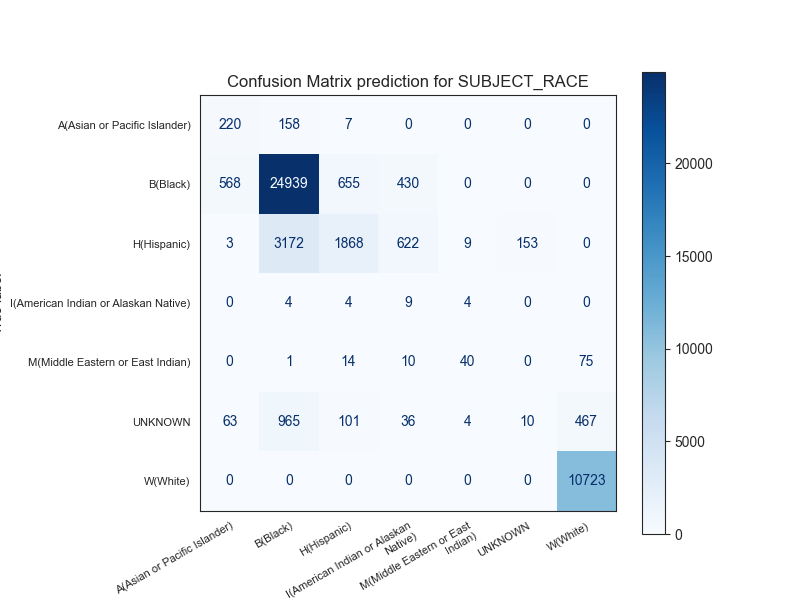

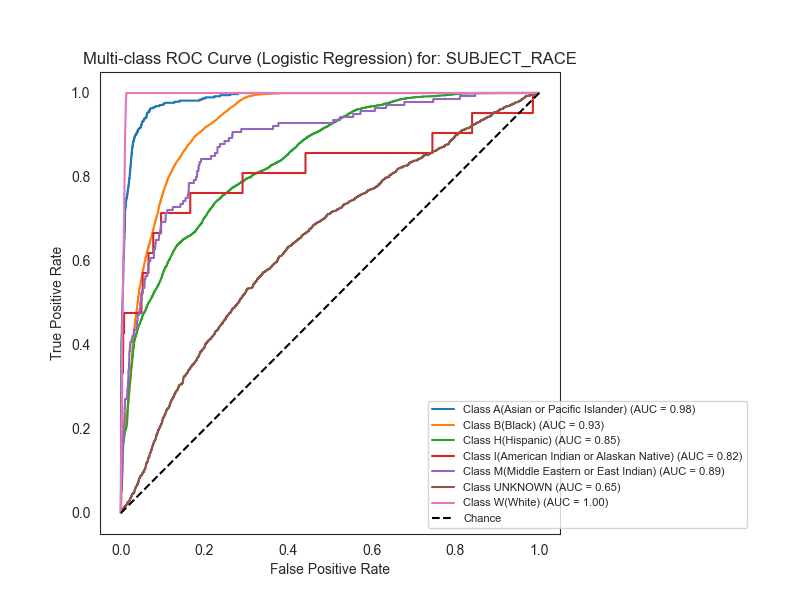

Python(37008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37023) Malloc

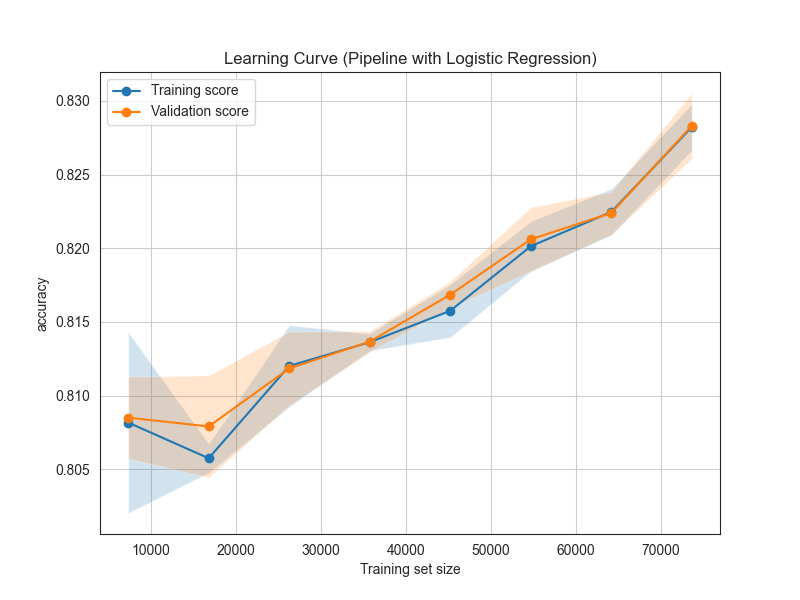

In [88]:
y_race_pred = train_predict_classification_pipeline(
    pipeline=race_pipeline, 
    X_train=race_X_train, 
    X_test=race_X_test, 
    y_train=race_y_train, 
    y_test=race_y_test,
    target_col='SUBJECT_RACE'
    )

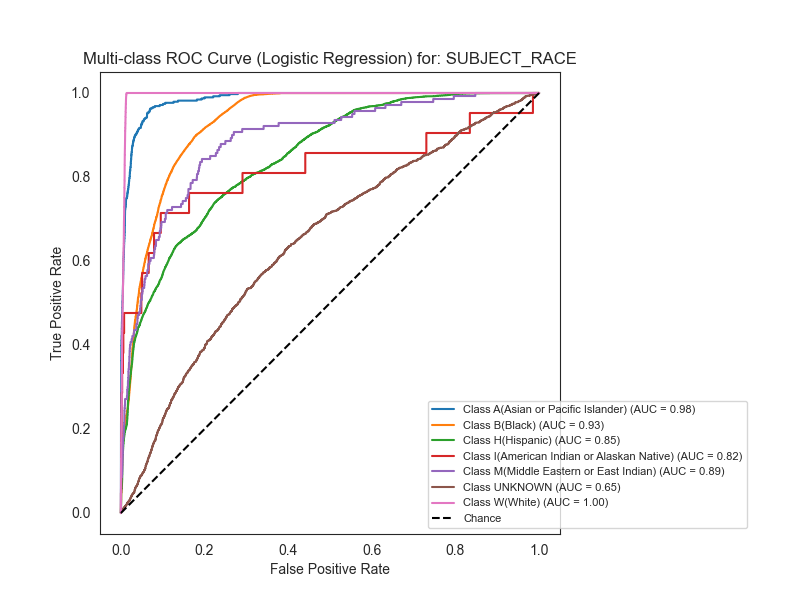

In [76]:
plot_roc(pipeline=race_pipeline, X_test=race_X_test, y_test=race_y_test, target_col='SUBJECT_RACE')

### Running the pipeline for target column VIOLATION_TYPE

In [87]:
vio_coef_df, vio_pipeline,  vio_X_train, vio_X_test, vio_y_train, vio_y_test = pipeline_runner(merged_dpt_census, target_col="GROUPED_VIOLATION_REASON")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .........selector__estimator__C=0.01;, score=nan total time=  19.7s
[CV 2/5] END .........selector__estimator__C=0.01;, score=nan total time=  21.1s
[CV 3/5] END .........selector__estimator__C=0.01;, score=nan total time=  21.1s
[CV 4/5] END .........selector__estimator__C=0.01;, score=nan total time=  21.1s
[CV 5/5] END .........selector__estimator__C=0.01;, score=nan total time=  18.4s
[CV 1/5] END .........selector__estimator__C=0.02;, score=nan total time=  36.4s
[CV 2/5] END .........selector__estimator__C=0.02;, score=nan total time=  39.0s
[CV 3/5] END .........selector__estimator__C=0.02;, score=nan total time=  42.9s
[CV 4/5] END .........selector__estimator__C=0.02;, score=nan total time=  40.2s
[CV 5/5] END .........selector__estimator__C=0.02;, score=nan total time=  39.5s
[CV 1/5] END .........selector__estimator__C=0.03;, score=nan total time=  47.2s
[CV 2/5] END .........selector__estimator__C=0.03

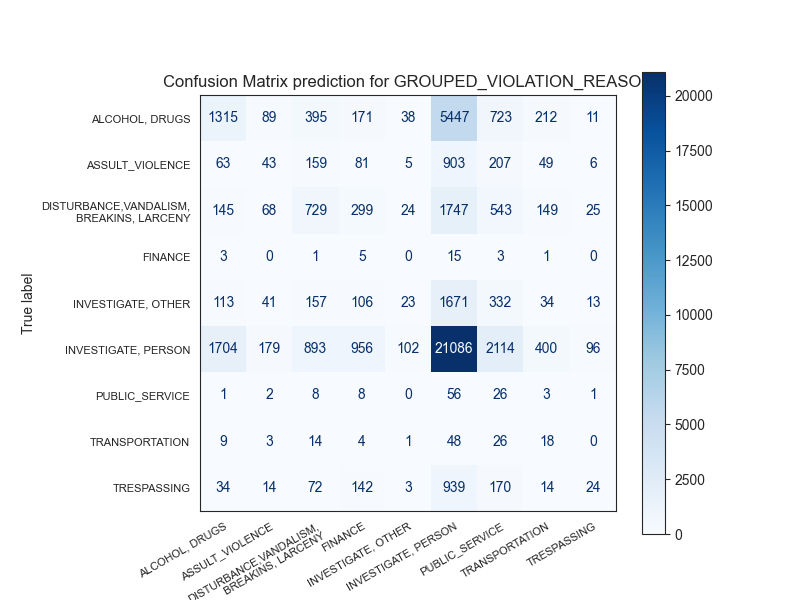

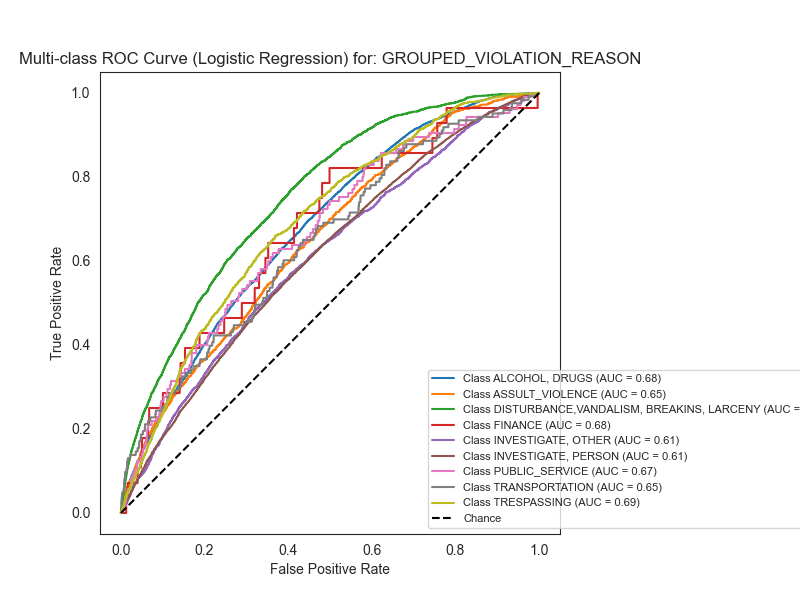

Python(37179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37180) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37256) Malloc

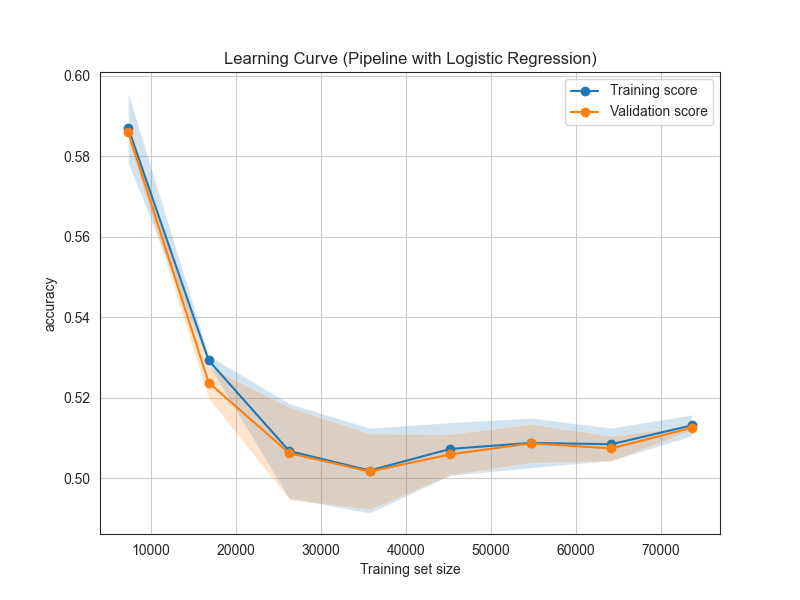

In [89]:
y_pred_vio = train_predict_classification_pipeline(
    pipeline=vio_pipeline, 
    X_train=vio_X_train, 
    X_test=vio_X_test, 
    y_train=vio_y_train, 
    y_test=vio_y_test,
    target_col='GROUPED_VIOLATION_REASON')

### Running the pipeline for target column OUTCOME

In [51]:
out_coef_df, out_pipeline,  out_X_train, out_X_test, out_y_train, out_y_test = pipeline_runner(merged_dpt_census, target_col="OUTCOME")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .........selector__estimator__C=0.01;, score=nan total time=  51.5s
[CV 2/5] END .........selector__estimator__C=0.01;, score=nan total time=  32.8s
[CV 3/5] END .........selector__estimator__C=0.01;, score=nan total time= 1.4min
[CV 4/5] END .........selector__estimator__C=0.01;, score=nan total time= 1.1min
[CV 5/5] END .........selector__estimator__C=0.01;, score=nan total time=  30.8s
[CV 1/5] END .........selector__estimator__C=0.02;, score=nan total time=  58.6s
[CV 2/5] END .........selector__estimator__C=0.02;, score=nan total time= 1.1min
[CV 3/5] END .........selector__estimator__C=0.02;, score=nan total time=  57.3s
[CV 4/5] END .........selector__estimator__C=0.02;, score=nan total time= 1.6min
[CV 5/5] END .........selector__estimator__C=0.02;, score=nan total time= 1.1min
[CV 1/5] END .........selector__estimator__C=0.03;, score=nan total time= 2.0min
[CV 2/5] END .........selector__estimator__C=0.03

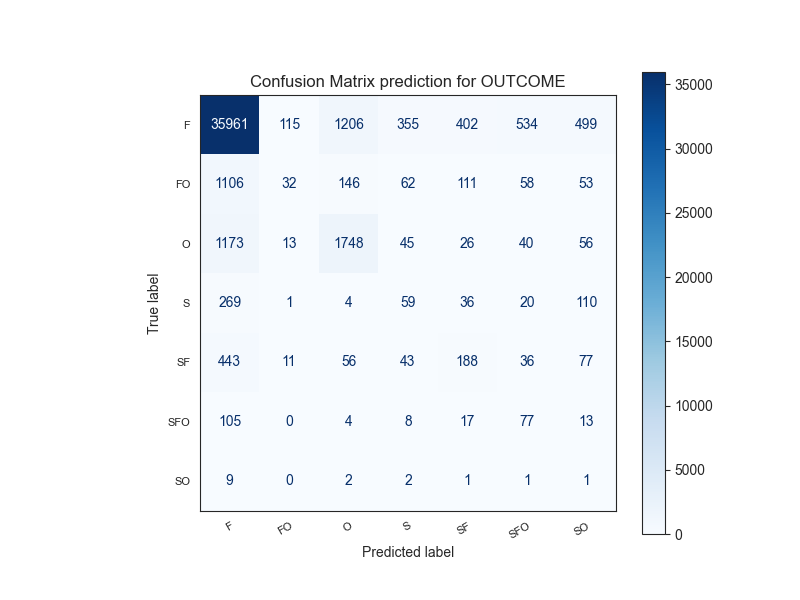

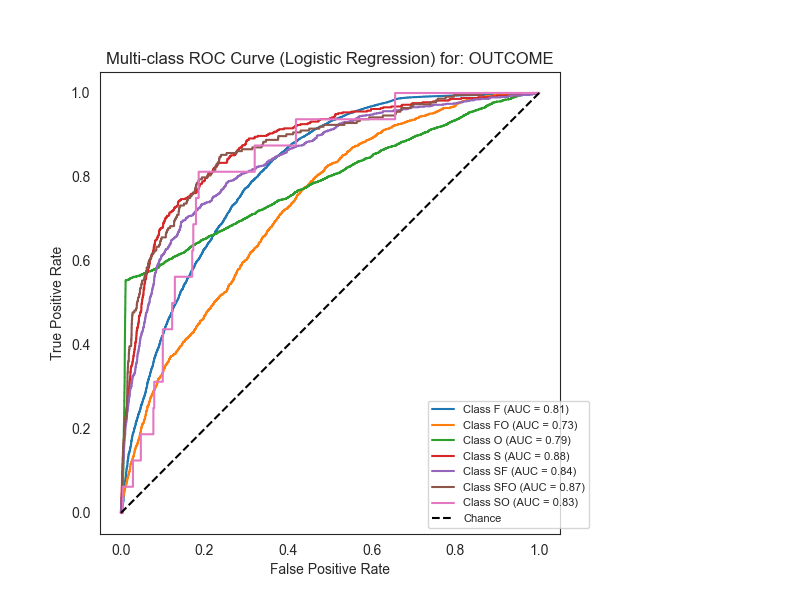

Python(37315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37334) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37361) Malloc

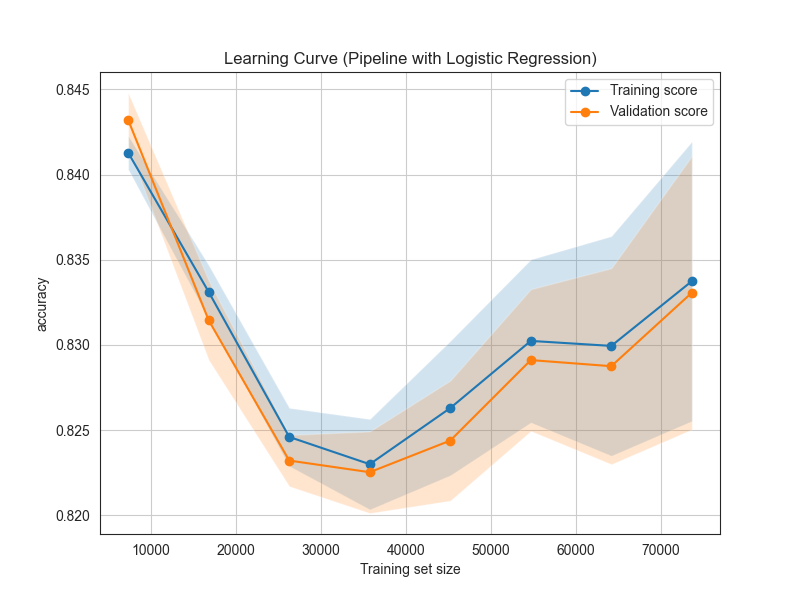

array(['F', 'F', 'F', ..., 'SO', 'F', 'F'], shape=(45334,), dtype=object)

In [90]:
train_predict_classification_pipeline(
    pipeline=out_pipeline, 
    X_train=out_X_train, 
    X_test=out_X_test, 
    y_train=out_y_train, 
    y_test=out_y_test,
    target_col='OUTCOME')